# NLP_GoingDeeper | P04. Seq2Seq_Translation_Kor2Eng
---
- 한국어 문장을 입력으로 하여 영어로 번역된 문장을 출력하는 번역기를 만들어봅니다. 
- Seq2Seq는 두 개의 RNN 모듈을 Encoder-Decoder 구조로 결합하여 사용합니다.
- Seq2Seq는 번역기에 최적화되어있기 때문에, Seq2Seq 기반 번역기를 직접 만들어봅니다. 
-  한국어-영어 말뭉치를 사용합니다. 
- (한국어 시각화를 위한 준비) matplotlib라이브러리의 기본 폰트는 한국어를 지원하지 않기 때문에, Attention Map을 확인하기 위해, 한국어를 지원하는 폰트로 변경해줍니다. 

In [1]:
# ! mkdir -p ~/aiffel/s2s_translation

In [2]:
#- 나눔글꼴 설치
! sudo apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 95 not upgraded.


In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/user/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

In [4]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


# 0. 데이터 불러오기
- korean-english-park.train dataset에는 약 9만 4천개의 한국어-영어 pair data가 포함되어 있습니다. 

In [5]:
cache_dir = '~/aiffel/GoingDeeper/DATA/s2s_translation'
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin = 'https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    cache_dir = cache_dir,
    extract=True
    )

In [6]:
path_to_ko = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
path_to_en = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"

In [7]:
with open(path_to_ko, "r") as f:
    raw_ko = f.read().splitlines()
with open(path_to_en, "r") as f:
    raw_en = f.read().splitlines()
print("Data Size:({},{})".format(len(raw_ko), len(raw_en)))
print("Example:")

# for sen in list(zip(raw_ko, raw_en))[0:100][::20]: print(">>", sen)

cnt = 0
for ko, en in zip(raw_ko, raw_en):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

# 1. 데이터 정제

## 1-1. 중복 데이터 제거
- set 데이터형을 이용하여 중복된 데이터를 제거할 수 있지만, 데이터의 병렬 쌍이 유지될 수 있도록 주의해야 합니다. 따라서 pandas의 dataframe을 활용하여 중복을 제거하겠습니다. 중복을 제거한 데이터는 cleaned_corpus에 저장합니다.


1. set을 이용하여 중복 제거 (pair 유지) < 훨씬 간단
2. dataframe의 drop_duplicated 활용 < 시각화 용이

In [8]:
#- 1. set을 이용하여 중복 제거 (pair 유지)
cleaned_corpus = list(set(zip(raw_ko, raw_en)))
len(cleaned_corpus)

78968

In [9]:
#- 2. dataframe의 drop_duplicated 활용
import pandas as pd
pair_df = pd.DataFrame({'Korean':raw_ko, 'English':raw_en})
pair_df

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [10]:
pair_df[pair_df.duplicated()]

,Korean,English
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
9925,*판매 제품,The goods
10070,* 알아두면 좋은 것:,Good to know:
10074,* 알아두면 좋은 것:,Good to know:
10079,* 알아두면 좋은 것:,Good to know:
...,...,...
93792,"힐러리 클린턴, 북한 방문할까",Would Hillary Clinton visit North Korea?
93793,"이라크 새 의회, 첫 개정",Iraq’s new assembly is going to hold its first...
93933,"노 대통령 검찰, 민주적 통제 받아야 2005.12",Roh says prosecutors need civilian control.
94002,"카우치 멤버, 사전 모의 시인 2005.09",Members of The Couch planned it before the show.


- 약 1만 5천여개의 중복 데이터쌍이 존재합니다. 

In [11]:
pair_df.drop_duplicates(inplace=True)
print(pair_df.shape)
pair_df[pair_df.duplicated()]

(78968, 2)


,Korean,English


- 중복 데이터쌍 제거 후, 약 7만 8천여개의 데이터쌍이 남았습니다.

## 1-2. preprocessing
- 한글에 적용할 수 있는 정규식을 추가하여 preprocessing을 진행합니다.
- 타겟 언어인 영문에는 \<start\> 토큰과 \<end\>토큰을 추가하고 split() 함수를 이용하여 토큰화합니다.

In [12]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    
    #- 단어와 구두점(punctuation)사이의 거리 생성
    sentence = re.sub(r"([?.!,])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
    # (ㄱ-ㅎ, ㅏ-ㅣ 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip() #- 양쪽 공백 제거
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [13]:
enc_corpus = []
dec_corpus = []

for pair in cleaned_corpus:
    ko, en = pair[0], pair[1]
    enc_corpus.append(preprocess_sentence(ko))
    dec_corpus.append(preprocess_sentence(en, s_token=True, e_token=True))

print("Korean:", enc_corpus[2500])
print("English:", dec_corpus[2500])

Korean: 전체 광고에서 매케인은 이미 기자들에게 년 전 일자부터 년간 건강 기록부를 기자들에게 얼핏 보여주도록 허락했던 반면 오바마는 자신의 주치의의 의견이 간략하게 담긴 페이지 분량의 내용만 공개했다는 사실을 가볍게 언급했다 .
English: <start> All this skates over the fact that McCain already allowed reporters a peek at eight years worth of health records , dating back to , while Obama has released a one page summary from his doctor . <end>


# 2. 데이터 토큰화
- tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각 tokenizer를 얻습니다. 단어의 수는 실험을 통해 적당한 값을 맞춥니다. (최소 10,000이상)
- 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. 
- cleaned_corpus 로부터 토큰의 길이가 40이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축합니다. 
- keras Tokenizer.index에서 num_words인자 설정에 따라 이후 사용되는 vocab의 사이즈가 결정됩니다. 
- 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않겠습니다. 
- 참고 : [What does Keras Tokenizer num_words specify?](https://stackoverflow.com/questions/64158898/what-does-keras-tokenizer-num-words-specify)

In [14]:
# #- Konlpy Mecab 설치 
# ! sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl
# ! python3 -m pip install --upgrade pip
# ! python3 -m pip install konlpy 
# ! sudo apt-get install curl git 
# ! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [15]:
from konlpy.tag import Mecab
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
def tokenize(corpus, vocab_size = 30000, maxlen=40, mecab=False):
    
    if mecab:
        mecab = Mecab()
        x_train = []
        for sen in corpus:
            x = mecab.morphs(sen)
            x_train.append(x)
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(vocab_size)
        vocab = ['','']+[key for key,_ in counter]
        word_to_index = {word : index for index, word in enumerate(vocab)} #- word : index 사전
        
        word_to_index["<PAD>"] = 0
        word_to_index["<UNK>"] = 1
        
        def wordlist_to_indexlist(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
        
        x_train = list(map(wordlist_to_indexlist, x_train))
        

        index_to_word = {index:word for word, index in word_to_index.items()}

        x_train = pad_sequences(x_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)
        
        return x_train, word_to_index

    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
        tokenizer.fit_on_texts(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=maxlen, padding='post')
        return tensor, tokenizer

In [17]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus, vocab_size = 30000-3, maxlen=40, mecab=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, vocab_size = 30000+1, maxlen=40, mecab=False)

# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_tensor, dec_tensor, test_size=0.2)

In [18]:
print("Korean Vocab Size:", len(enc_tokenizer))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 30000
English Vocab Size: 44689


In [19]:
#- ko-en 모두 subword tokenize

# 3. 모델 설계
- Attention 기반 Seq2seq 모델을 설계합니다.
- dropout 모듈을 추가하여 성능향상을 시켜봅니다. 
- Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰줍니다. 

In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        # score shape == (batch_size, max_length, 1)
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # attention weights shape == (batch_size, max_length, 1)
        attn = tf.nn.softmax(score, axis=1)
        
        # context vector shape after sum == (batch_size, hidden_size)
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       dropout=0.3,
                                       return_sequences=True)
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       dropout=0.3,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
    
    
    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [22]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# 4. 훈련


In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [24]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1234/1234 [33:08<00:00,  1.61s/it, Loss 1.5308]


# 5. 평가
- 아래 예문에 대한 번역을 생성해봅니다.
- Attention Map을 시각화합니다. 
## 예문 ##
```
K1) 오바마는 대통령이다.
>> obama is the president .
K2) 시민들은 도시 속에 산다.
>>  citizens are bracing for the city .
K3) 커피는 필요 없다.
>> there is no change .
K4) 일곱 명의 사망자가 발생했다.
>> the death toll was dead .
```

In [73]:
def evaluate(sentence, encoder, decoder):
    mecab = Mecab()
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = mecab.morphs(sentence)
    inputs = [[enc_tokenizer[word] if word in enc_tokenizer else enc_tokenizer["<UNK>"] for word in sentence]]
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                        value=enc_tokenizer["<PAD>"],
                        padding='post',
                        maxlen=enc_tensor.shape[-1])
    print(inputs)

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))


[[110, 5, 47, 4, 3, 2]]
[[110   5  47   4   3   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the president . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


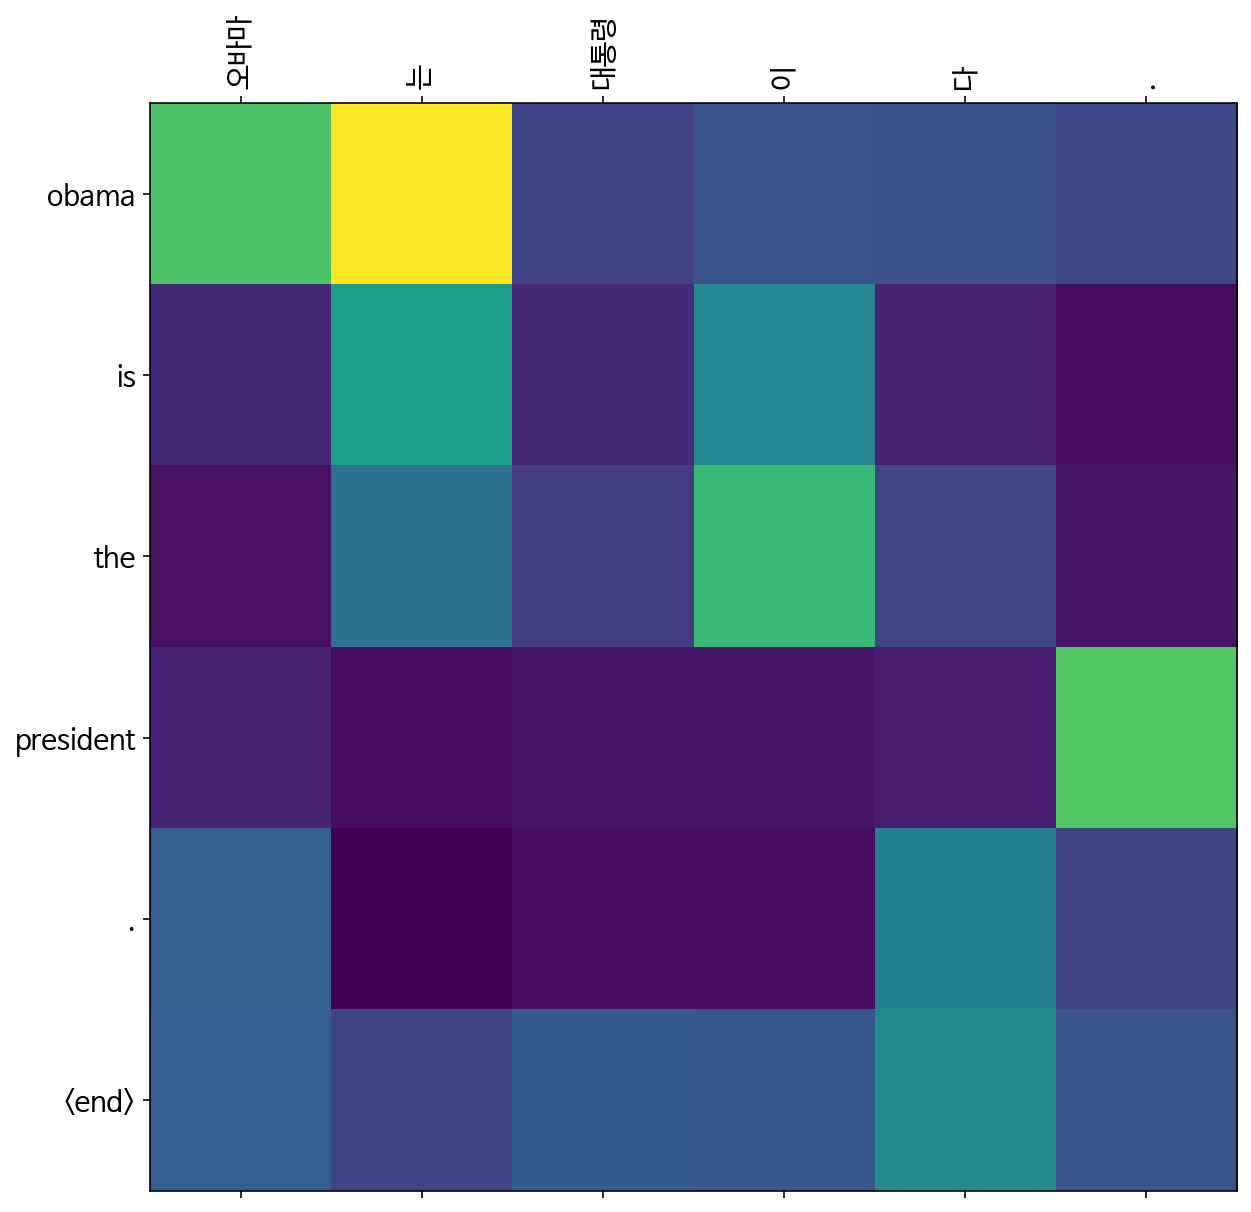

[[514, 15, 9, 322, 577, 8, 1, 2]]
[[514  15   9 322 577   8   1   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: citizens are bracing for the city . <end> 


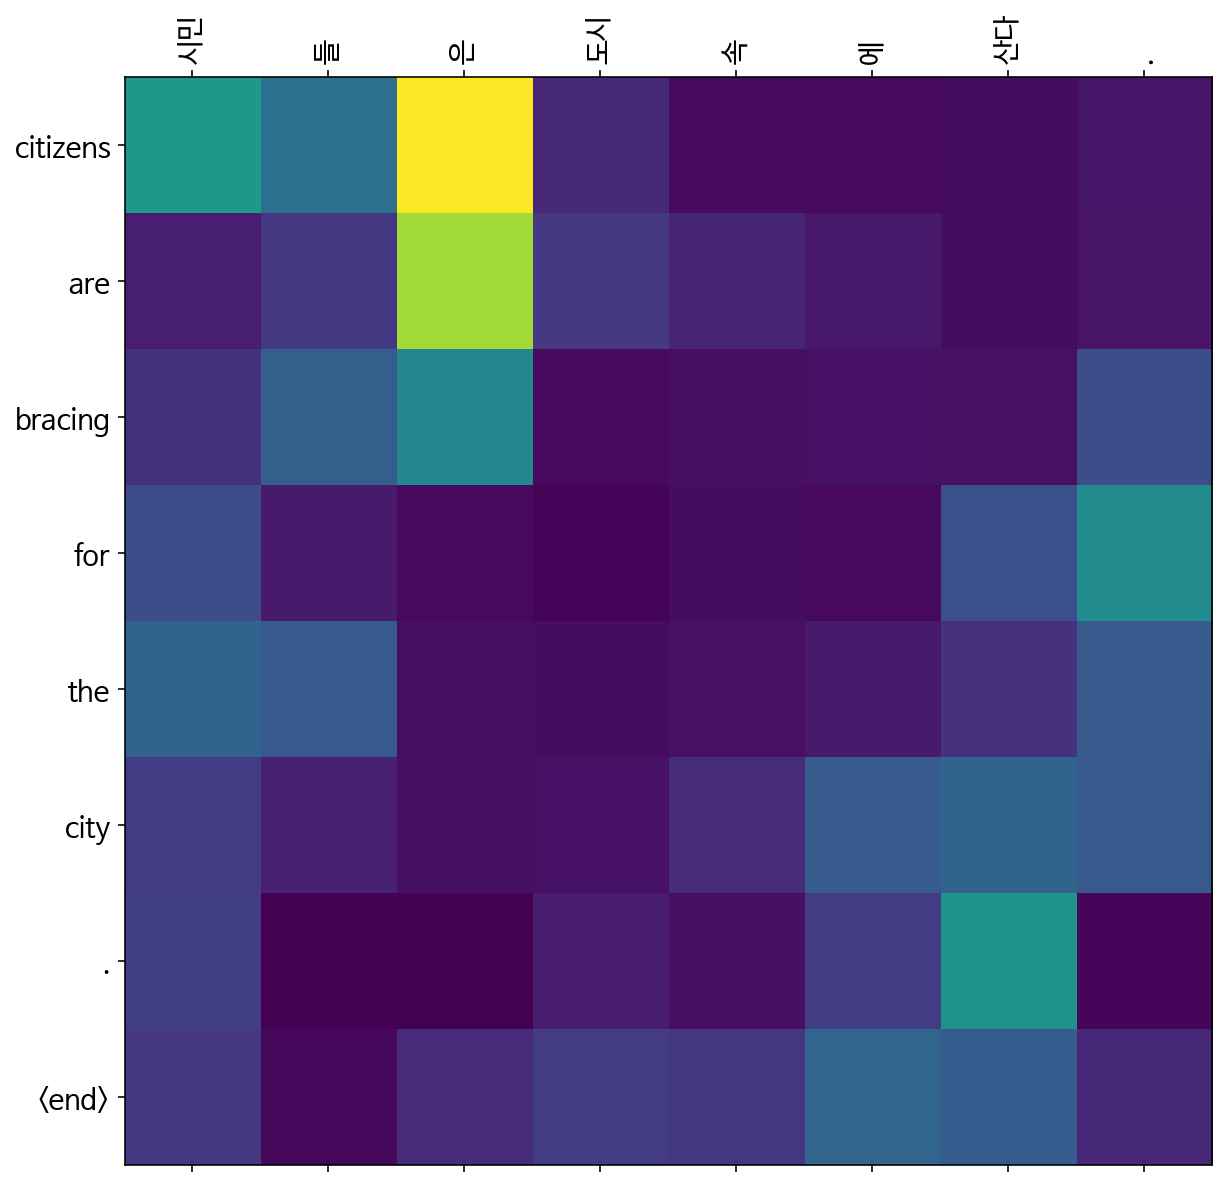

[[2677, 5, 222, 69, 3, 2]]
[[2677    5  222   69    3    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: there is no change . <end> 


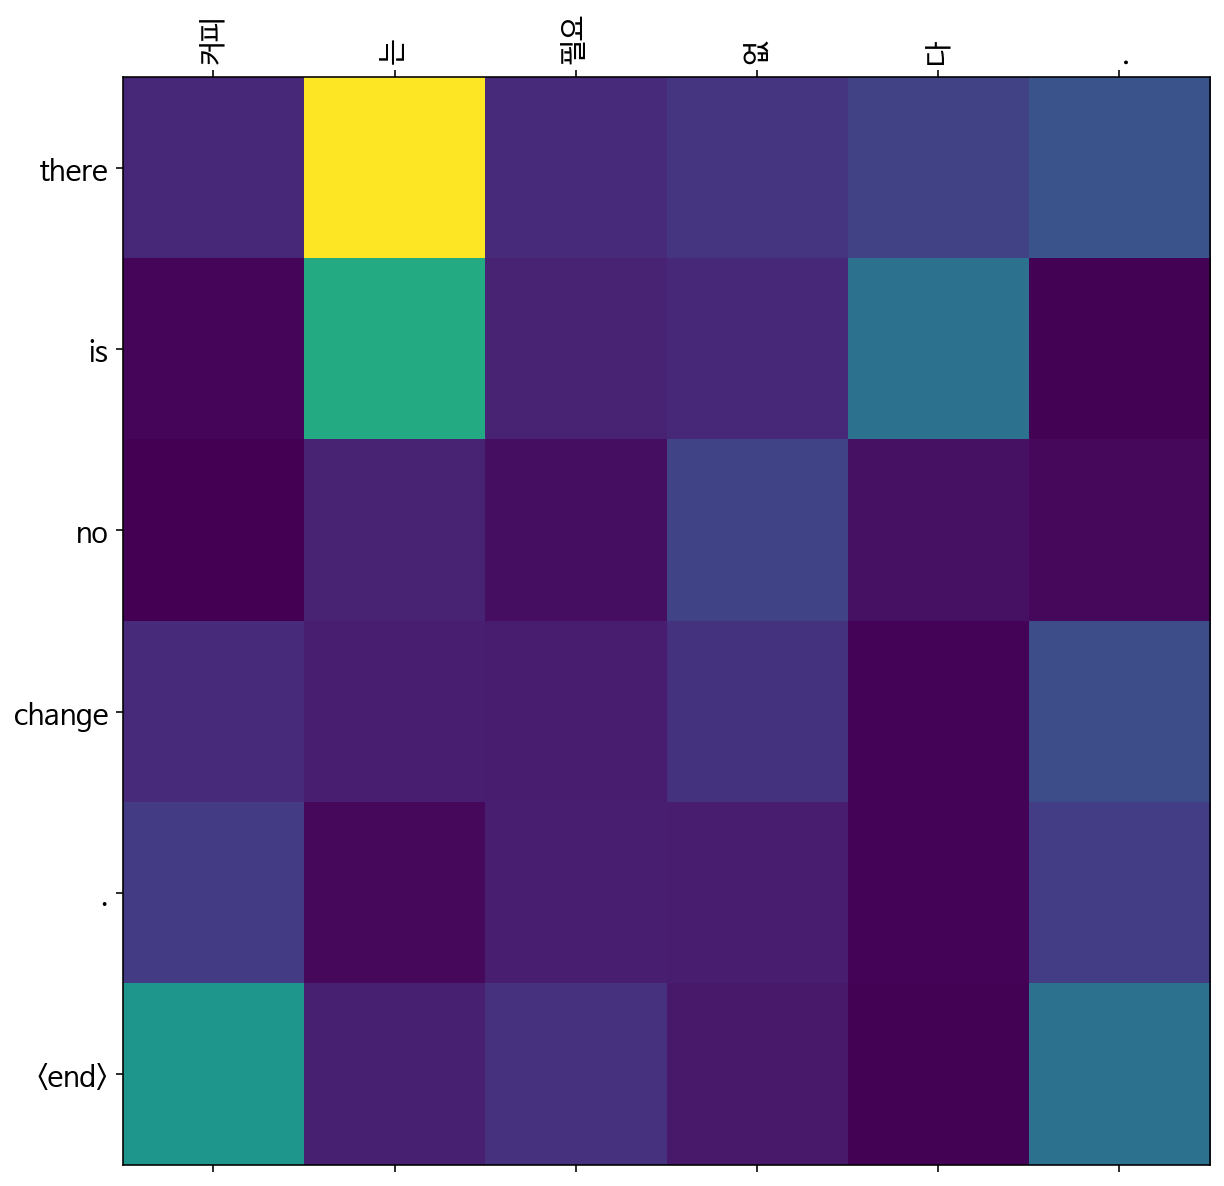

[[6089, 33, 7, 517, 16, 89, 12, 3, 2]]
[[6089   33    7  517   16   89   12    3    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the death toll was dead . <end> 


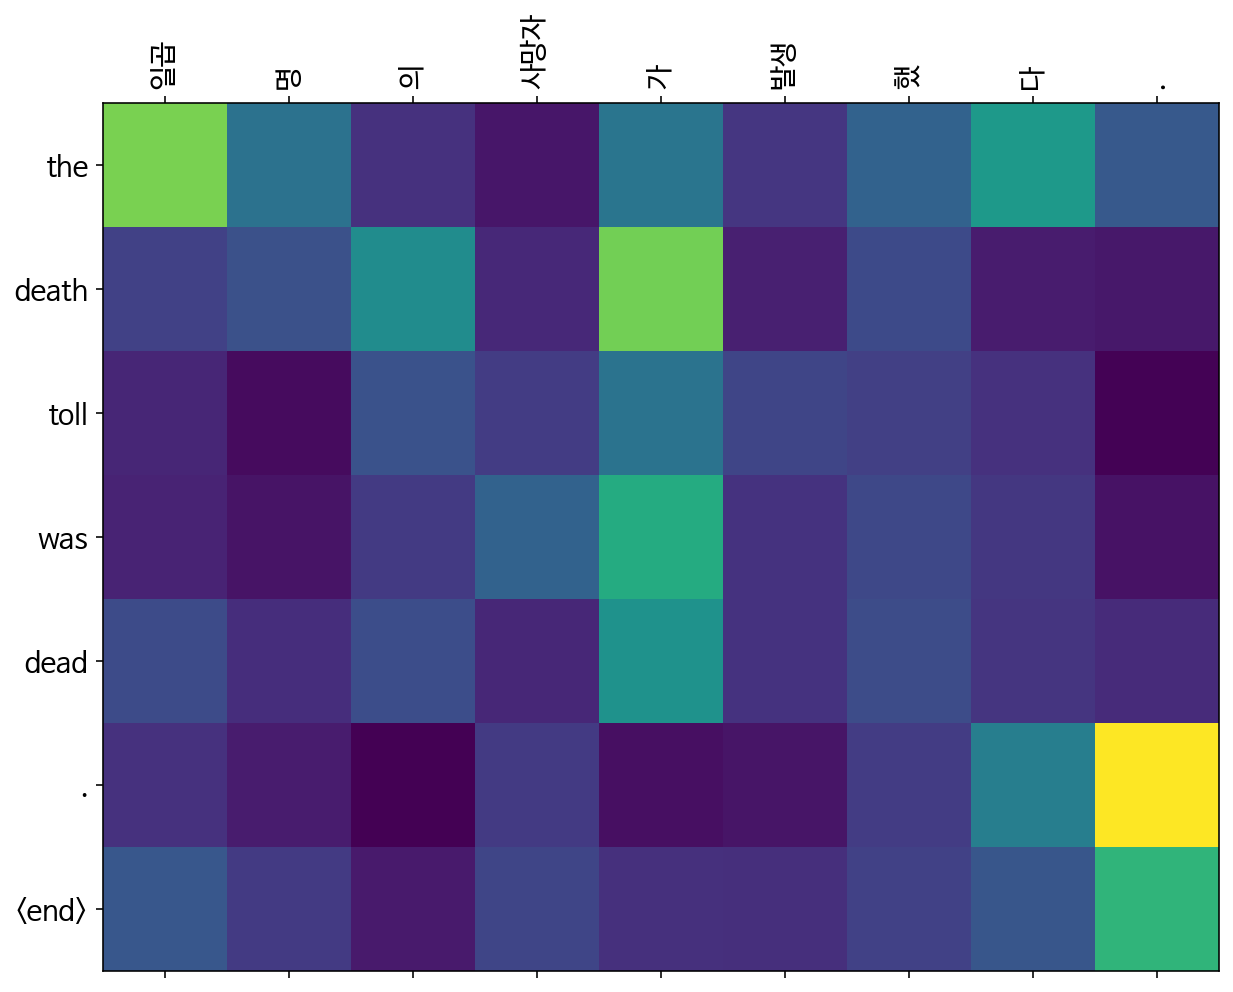

In [74]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

[[3288, 589, 1025, 19, 1623, 4, 1, 104, 227, 2]]
[[3288  589 1025   19 1623    4    1  104  227    2    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['내일', '밤', '강력', '한', '폭풍', '이', '몰아칠', '예정', '입니다', '.']
Predicted translation: the big storm is expected to be a big storm is tomorrow s walk today . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


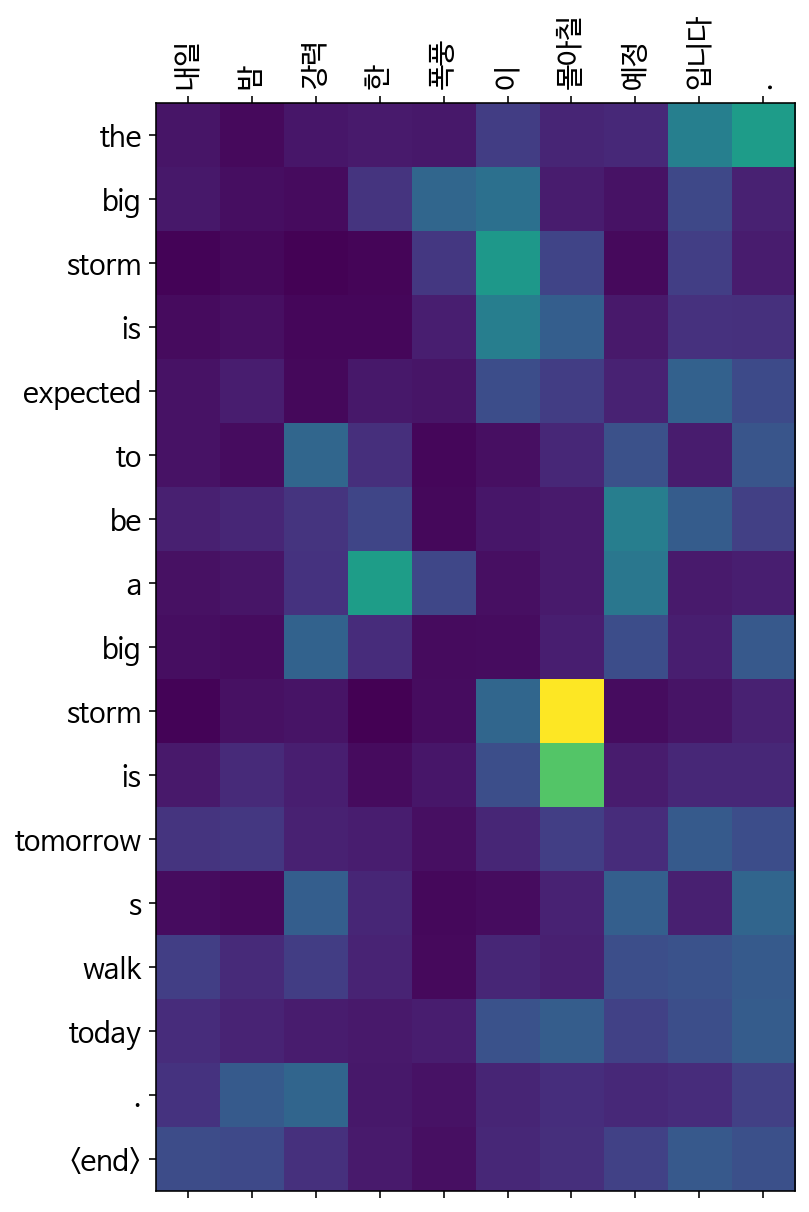

In [75]:
translate("내일 밤 강력한 폭풍이 몰아칠 예정입니다.", encoder, decoder)

[[306, 5, 514, 7, 1129, 4, 3]]
[[ 306    5  514    7 1129    4    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['투표', '는', '시민', '의', '권리', '이', '다']
Predicted translation: the vote is to be the right to be a democratic party . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


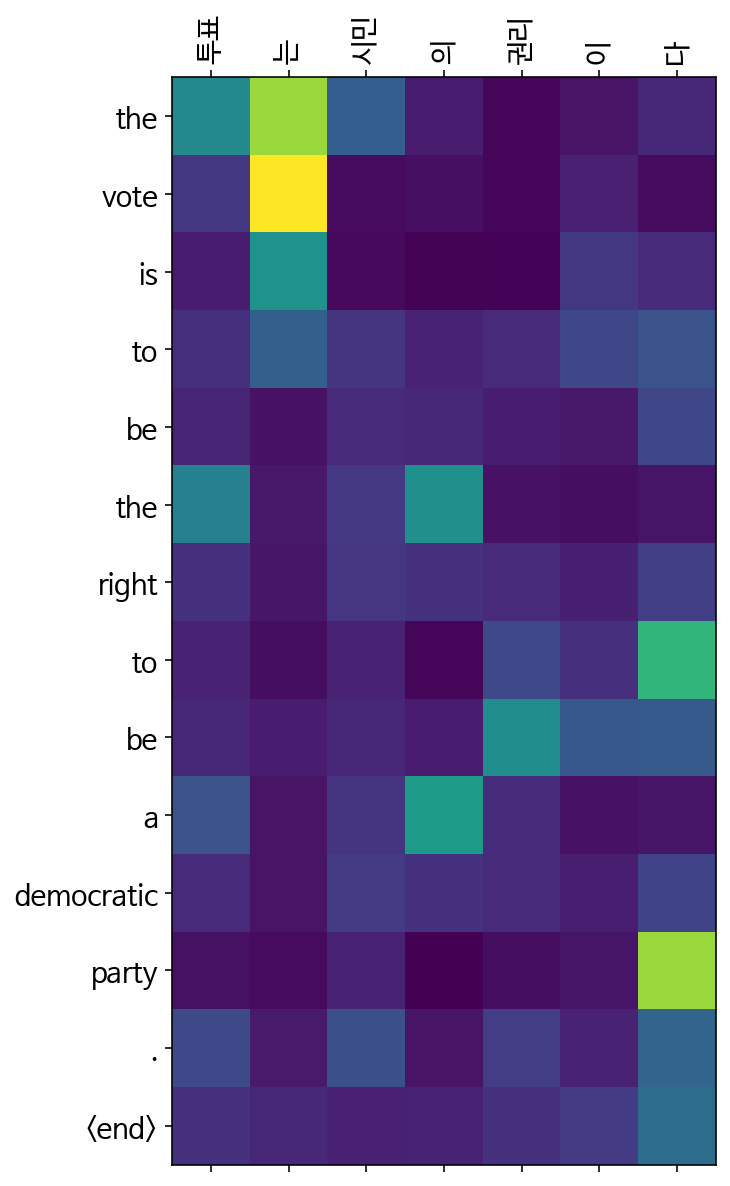

In [76]:
translate("투표는 시민의 권리이다", encoder, decoder)

[[4081, 154, 578, 16, 19, 344, 8, 208, 13, 14, 65, 2]]
[[4081  154  578   16   19  344    8  208   13   14   65    2    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['곰', '세', '마리', '가', '한', '집', '에', '살', '고', '있', '습니다', '.']
Predicted translation: the remainder are in the house . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


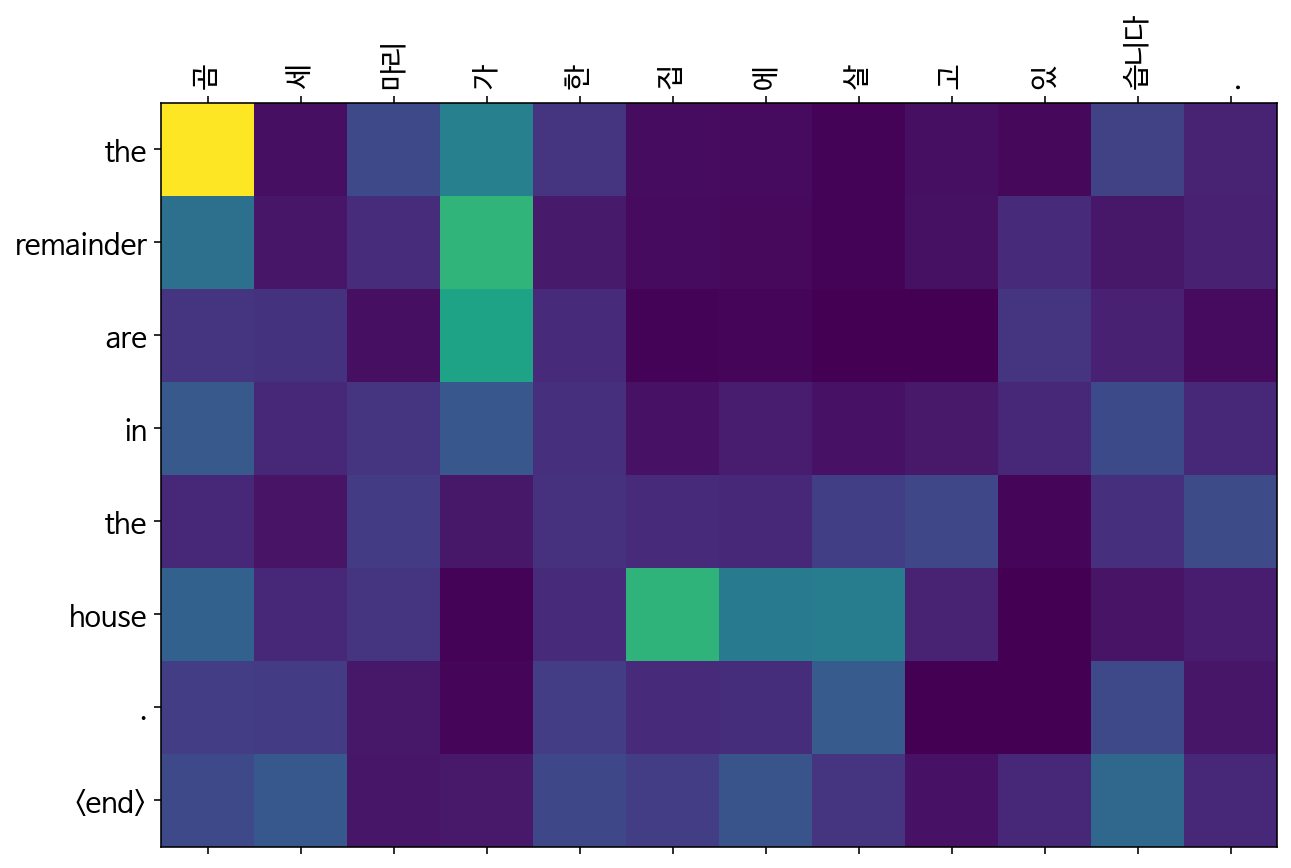

In [77]:
translate("곰 세마리가 한집에 살고 있습니다.", encoder, decoder)

[[480, 66, 5, 10254, 10770, 18, 1, 18, 20481, 7, 265, 31, 24, 702, 4, 3, 2]]
[[  480    66     5 10254 10770    18     1    18 20481     7   265    31
     24   702     4     3     2     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Input: ['음', '주', '는', '만성', '간염', ',', '간경변증', ',', '간암', '의', '대표', '적', '인', '원인', '이', '다', '.']
Predicted translation: the remainder are the latest in the united states , a major , the middle east , a , and the united states , a , and the united states , a , and the united states , a , 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


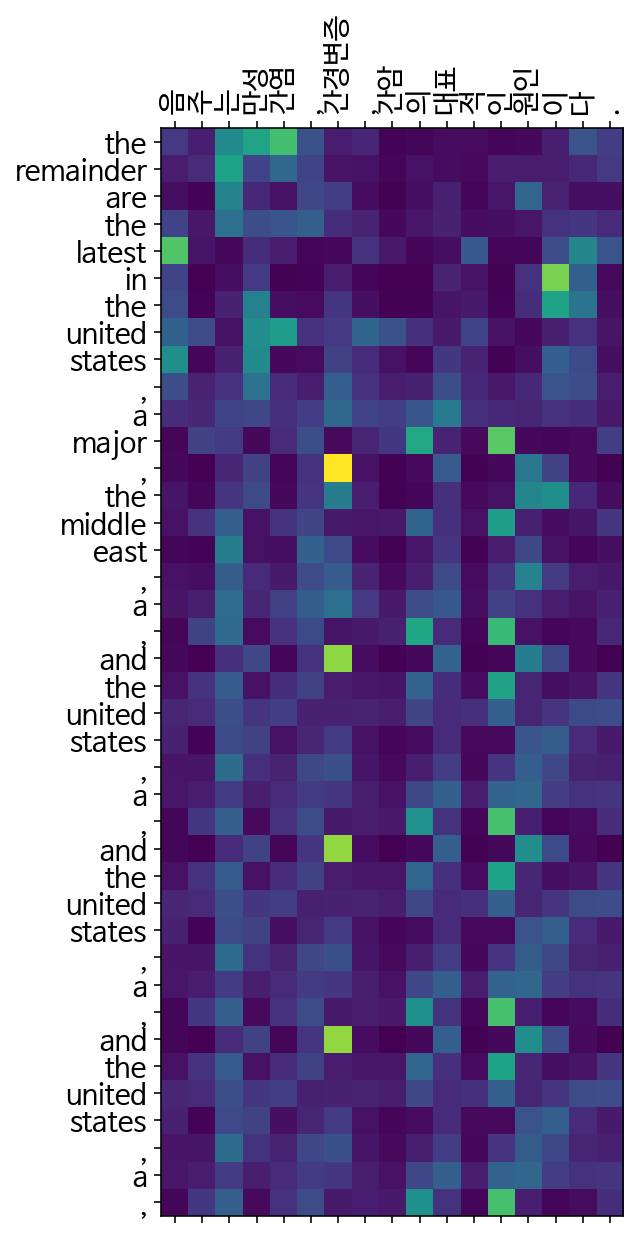

In [79]:
translate("음주는 만성간염, 간경변증, 간암의 대표적인 원인이다. ", encoder, decoder)

[[1, 607, 9, 862, 31, 21, 29511, 7, 529, 145, 1556, 22, 744, 11, 5, 607, 6, 16264, 421, 2]]
[[    1   607     9   862    31    21 29511     7   529   145  1556    22
    744    11     5   607     6 16264   421     2     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Input: ['극초음속', '미사일', '은', '일반', '적', '으로', '음속', '의', '배', '이상', '속도', '로', '비행', '하', '는', '미사일', '을', '일컫', '는다', '.']
Predicted translation: the missile is about a space station . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


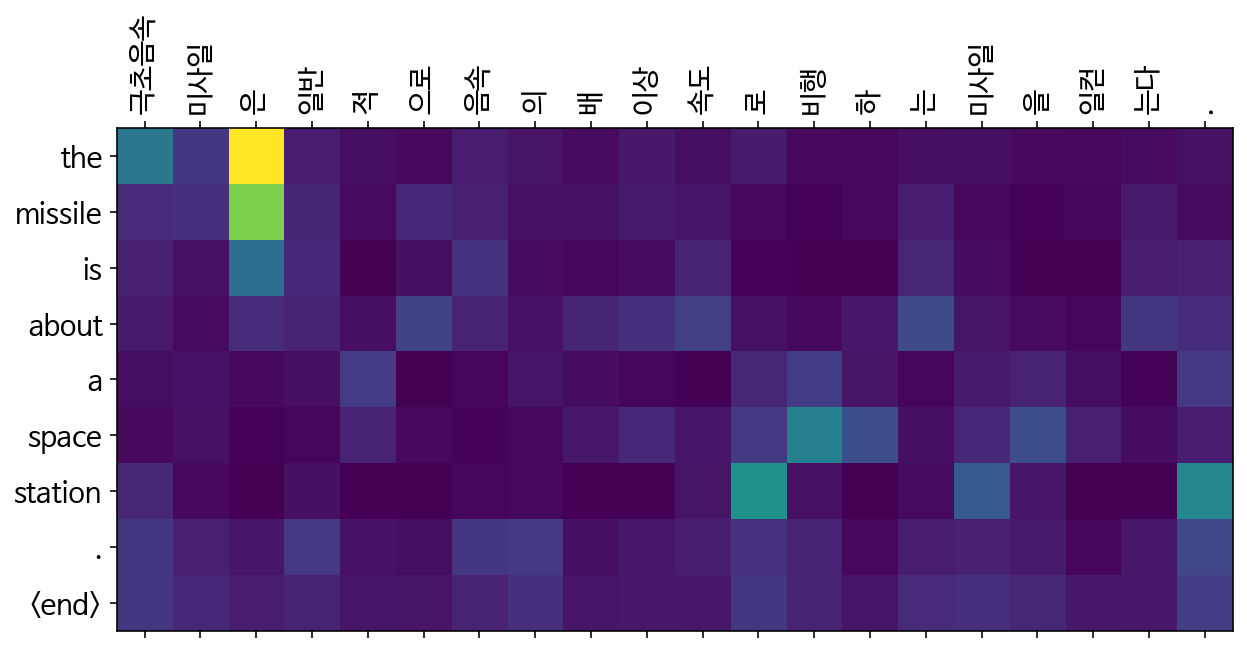

In [80]:
translate("극초음속 미사일은 일반적으로 음속의 5배 이상 속도로 비행하는 미사일을 일컫는다.", encoder, decoder)


[[4056, 847, 357, 6, 1, 44, 504, 6722, 959, 16, 832, 15, 53, 6588, 19542, 6, 1, 20, 21, 843, 3, 2]]
[[ 4056   847   357     6     1    44   504  6722   959    16   832    15
     53  6588 19542     6     1    20    21   843     3     2     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Input: ['친환경', '에너지', '정책', '을', '펼쳐온', '미국', '조', '바이든', '행정부', '가', '올', '들', '어', '석탄', '사용량', '을', '늘린', '것', '으로', '나타났', '다', '.']
Predicted translation: but the bush administration is creating a problem of global warming . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


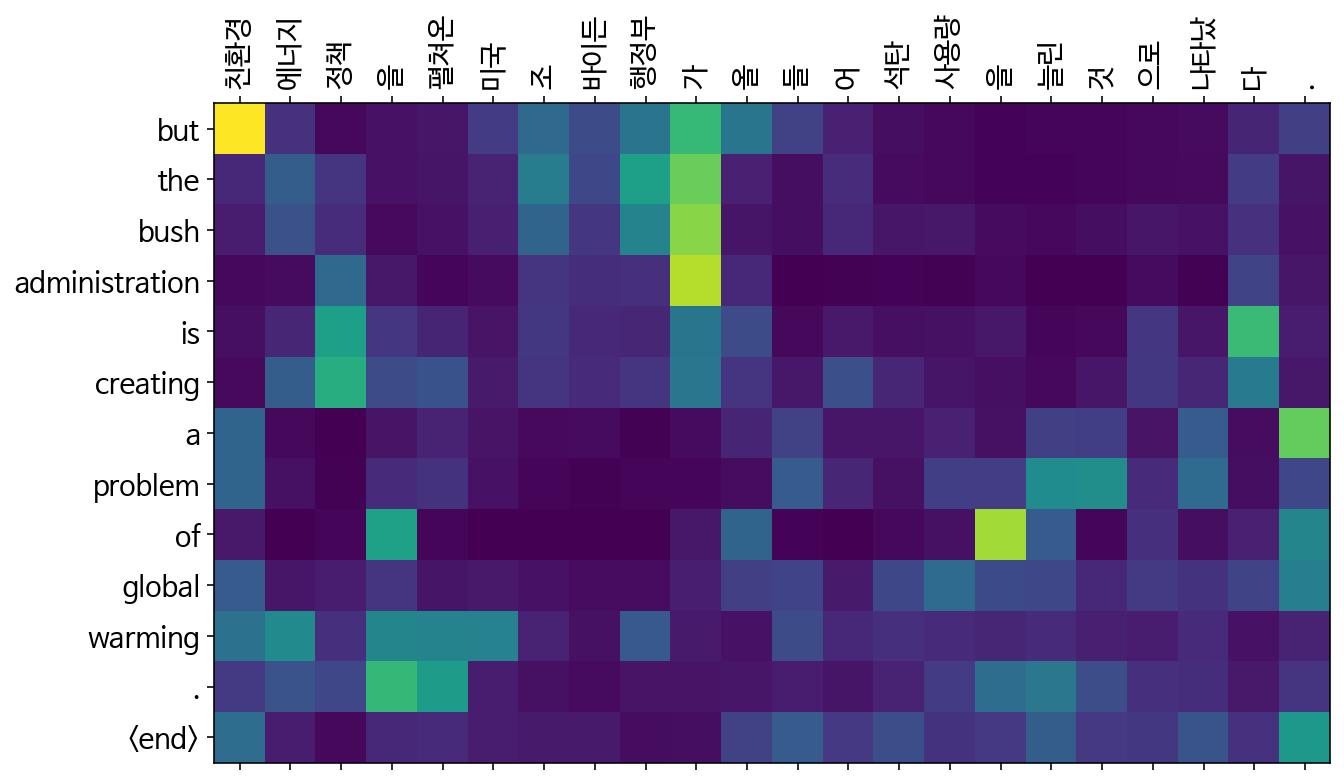

In [81]:
translate("친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다. ", encoder, decoder)

[[2677, 326, 7, 222, 100, 6, 969, 5, 5562, 5210, 9, 308, 25, 92, 3]]
[[2677  326    7  222  100    6  969    5 5562 5210    9  308   25   92
     3    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['커피', '중단', '의', '필요', '성', '을', '알리', '는', '카페인', '부작용', '은', '다음', '과', '같', '다']
Predicted translation: the caffeine is a combination of caffeine . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


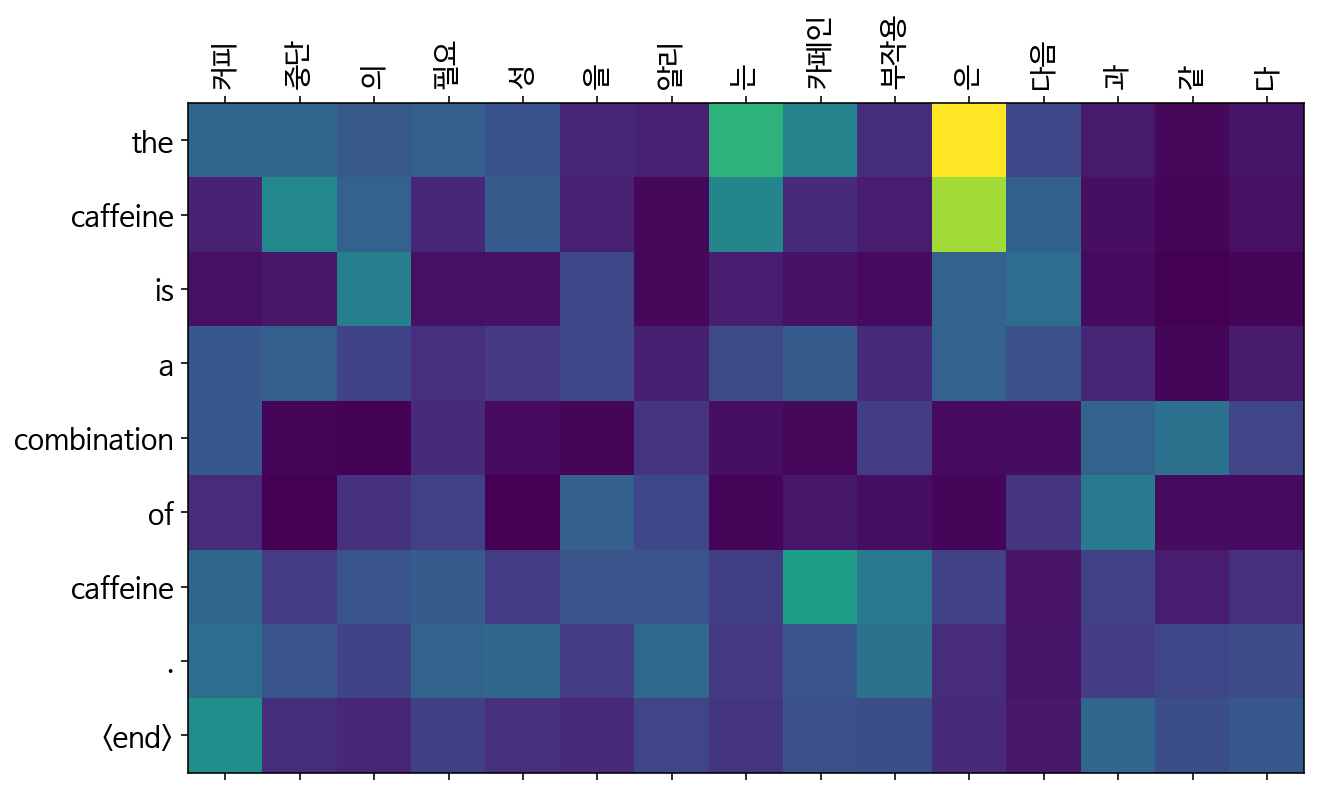

In [82]:
translate("커피중단의 필요성을 알리는 카페인 부작용은 다음과 같다", encoder, decoder)

[[215, 233, 9, 913, 8161, 254, 11381, 7, 273, 15, 150, 5, 1640, 6, 1494, 21, 1532, 5, 17856, 392, 4, 11047, 17, 9068, 72, 873, 5, 571, 15, 2997, 3414, 11, 46, 1, 142, 12, 3, 2]]
[[  215   233     9   913  8161   254 11381     7   273    15   150     5
   1640     6  1494    21  1532     5 17856   392     4 11047    17  9068
     72   873     5   571    15  2997  3414    11    46     1   142    12
      3     2     0     0]]
Input: ['연구', '팀', '은', '주변', '지형', '이나', '사물', '의', '위치', '들', '보다', '는', '방향', '을', '기준', '으로', '삼', '는', '탐색', '법', '이', '곤충', '에서', '영장류', '까지', '이르', '는', '동물', '들', '에게서', '광범위', '하', '게', '나타난다고', '설명', '했', '다', '.']
Predicted translation: the researchers describe their ancestors . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


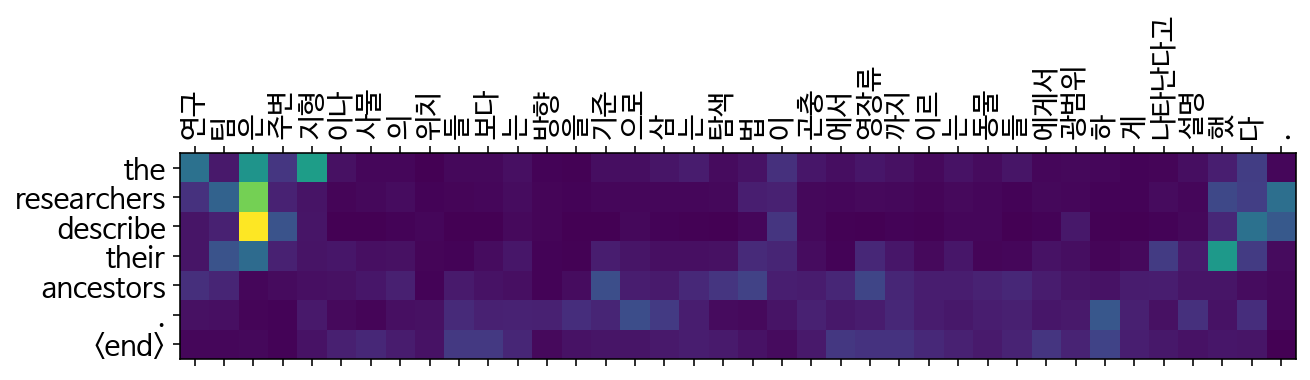

In [83]:
translate("연구팀은 주변 지형이나 사물의 위치들보다는 방향을 기준으로 삼는 탐색법이 곤충에서 영장류까지 이르는 동물들에게서 광범위하게 나타난다고 설명했다.", encoder, decoder)


[[735, 2512, 1774, 16, 8668, 20, 9, 4972, 52, 4470, 26, 11, 5, 1, 52, 1774, 16, 471, 46, 8668, 566, 21, 12707, 161, 2]]
[[  735  2512  1774    16  8668    20     9  4972    52  4470    26    11
      5     1    52  1774    16   471    46  8668   566    21 12707   161
      2     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Input: ['저', '임금', '근로자', '가', '늘어난', '것', '은', '매주', '시간', '미만', '일', '하', '는', '초단', '시간', '근로자', '가', '크', '게', '늘어난', '영향', '으로', '풀이', '된다', '.']
Predicted translation: the overall reduction of the total number of the total number of the total number of the total number of the total number of the total number of the total number of the total number of the total number of 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


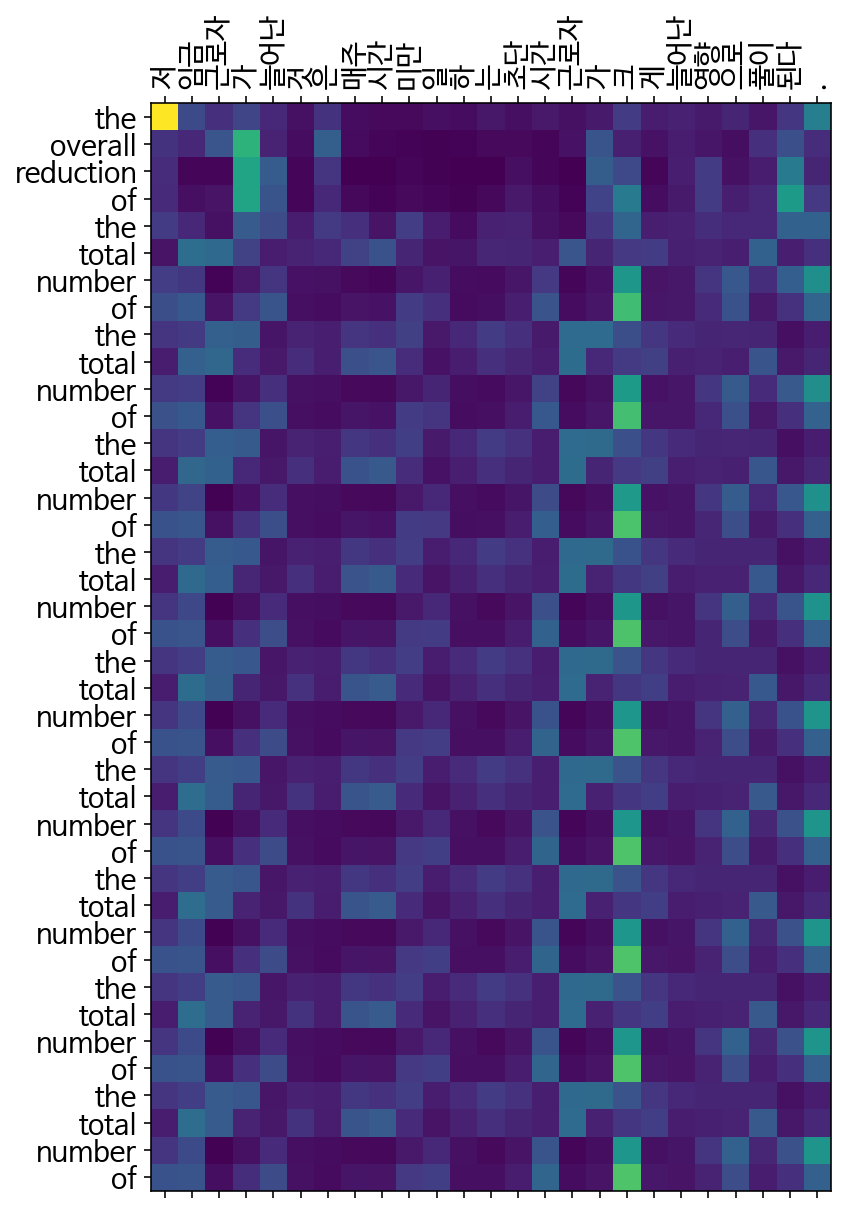

In [84]:
translate("저임금 근로자가 늘어난 것은 매주 17시간 미만 일하는 '초단시간' 근로자가 크게 늘어난 영향으로 풀이된다.", encoder, decoder)

[[27, 5, 3644, 1, 2321, 275, 15, 25, 9197, 10, 19, 230, 1, 7909, 6, 12, 3, 2]]
[[  27    5 3644    1 2321  275   15   25 9197   10   19  230    1 7909
     6   12    3    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['그', '는', '부산', '개인택시', '조합', '기사', '들', '과', '간담회', '를', '한', '뒤', '비빔밥', '오찬', '을', '했', '다', '.']
Predicted translation: he was elected to the south korean and the meeting with the group . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


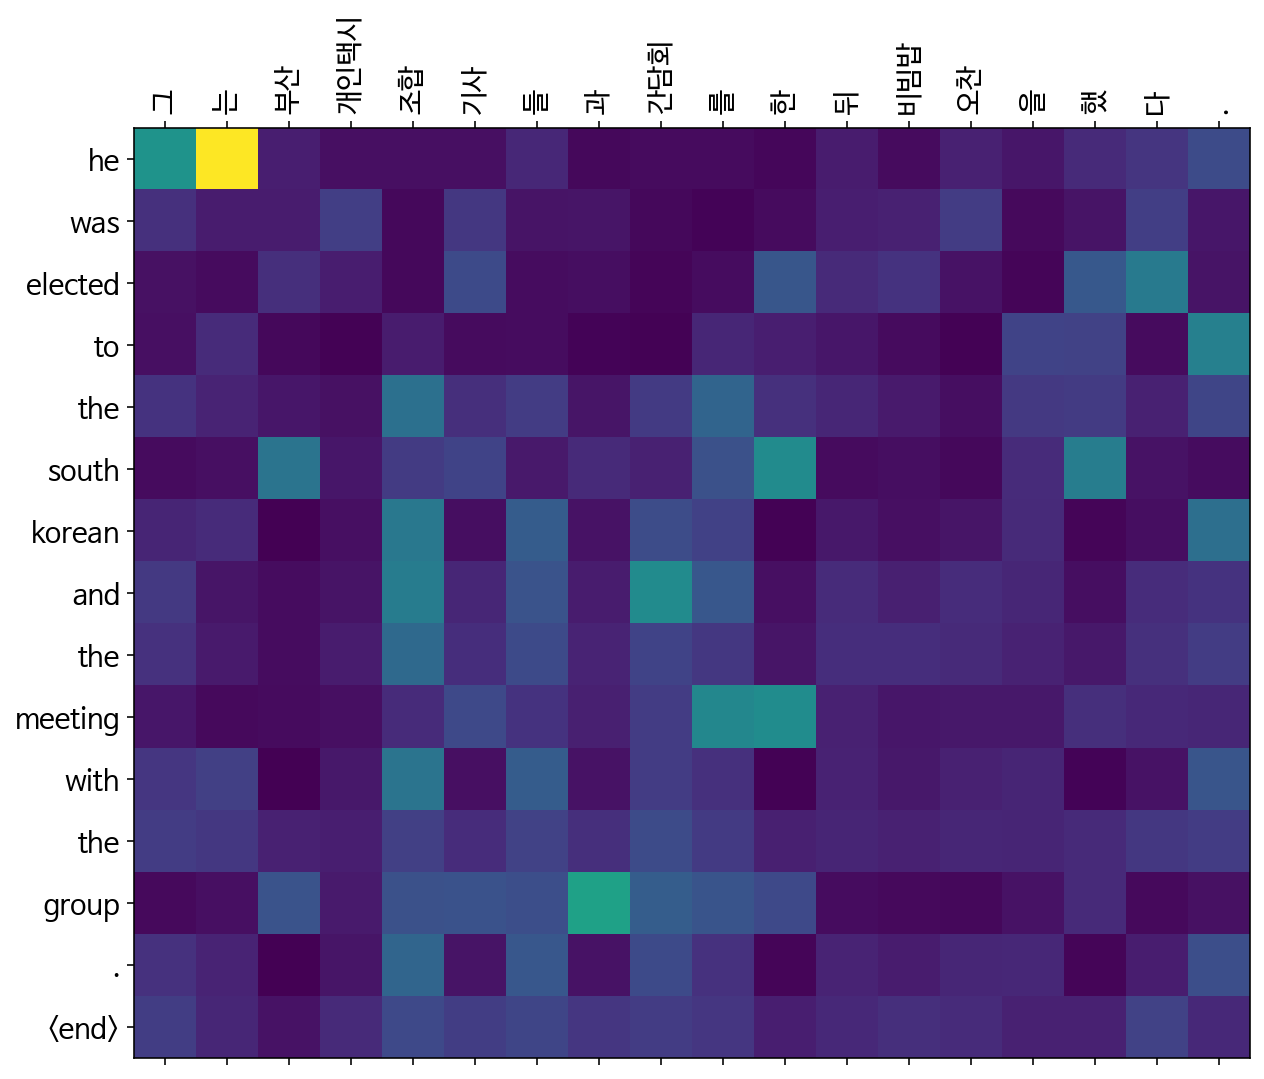

In [85]:
translate("그는 부산개인택시조합 기사들과 간담회를 한 뒤 비빔밥 오찬을 했다.", encoder, decoder)

[[2032, 269, 5, 242, 39, 50, 170, 1, 15327, 10, 7903, 49, 704, 677, 21, 3186, 55, 23, 73, 2]]
[[ 2032   269     5   242    39    50   170     1 15327    10  7903    49
    704   677    21  3186    55    23    73     2     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Input: ['박', '씨', '는', '몇', '년', '전', '국제', '마피', '아파', '를', '탈퇴', '해', '관심', '대상', '으로', '분류', '됐', '다고', '한다', '.']
Predicted translation: park is also known as a decade ago . <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


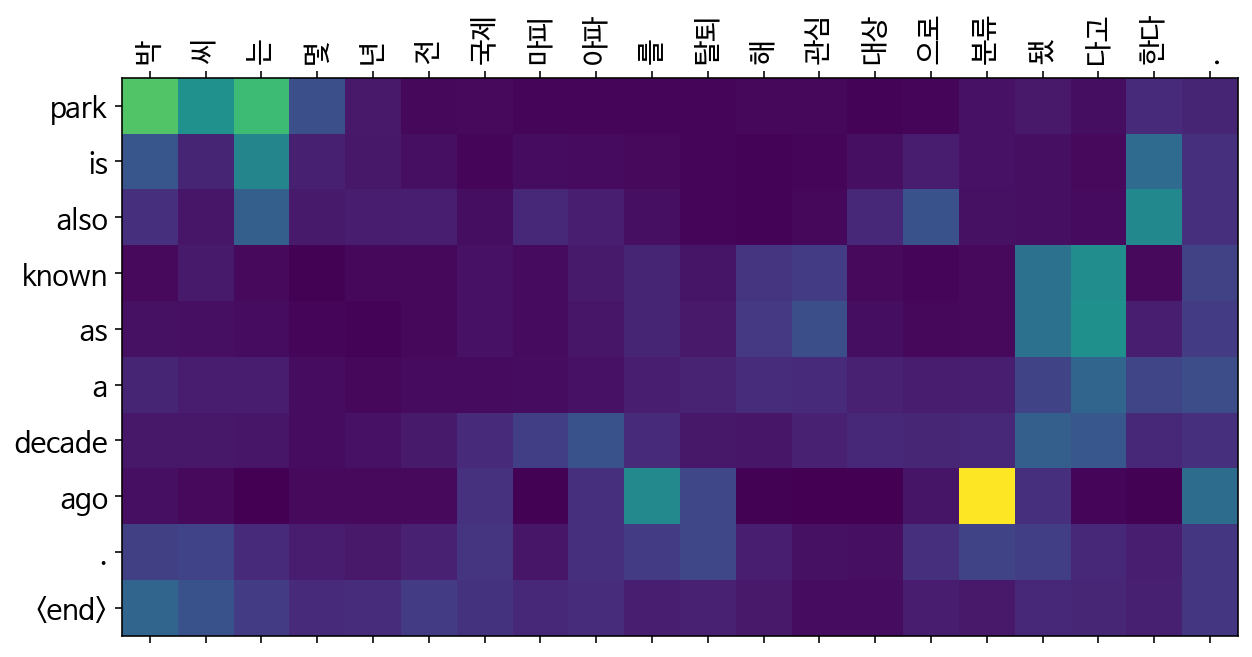

In [86]:
translate("박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.", encoder, decoder)



||입력(한국어)|출력(영어)|
|--|--|--|
|1|오바마는 대통령이다.|obama is the president .|
|2|시민들은 도시 속에 산다.|citizens are bracing for the city .|
|3|커피는 필요 없다.|there is no change .|
|4|일곱 명의 사망자가 발생했다.|the death toll was dead .|
|5|내일 밤 강력한 폭풍이 몰아칠 예정입니다.|the big storm is expected to be a big storm is tomorrow s walk today .|
|6|투표는 시민의 권리이다|the vote is to be the right to be a democratic party .|
|7|곰 세마리가 한집에 살고 있습니다.|the remainder are in the house .|
|8|음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.|the remainder are the latest in the united states , a major , the middle east , a , and the united states , a , and the united states , a , and the united states , a , |
|9|극초음속 미사일은 일반적으로 음속의 5배 이상 속도로 비행하는 미사일을 일컫는다|the missile is about a space station .|
|10|친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.|but the bush administration is creating a problem of global warming .|
|11|커피중단의 필요성을 알리는 카페인 부작용은 다음과 같다|the caffeine is a combination of caffeine . |
|12|연구팀은 주변 지형이나 사물의 위치들보다는 방향을 기준으로 삼는 탐색법이 곤충에서 영장류까지 이르는 동물들에게서 광범위하게 나타난다고 설명했다.|the researchers describe their ancestors .|
|13|저임금 근로자가 늘어난 것은 매주 17시간 미만 일하는 '초단시간' 근로자가 크게 늘어난 영향으로 풀이된다.|the overall reduction of the total number of the total number of the total number of the total number of the total number of the total number of the total number of the total number of the total number of |
|14|그는 부산개인택시조합 기사들과 간담회를 한 뒤 비빔밥 오찬을 했다.|he was elected to the south korean and the meeting with the group .|
|15|박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.|park is also known as a decade ago .|

- 전체적으로 문법은 잘 들어맞습니다. 
- 하지만 어휘, 문맥은 엇나가는 경우가 자주 보이는데, 이는 데이터의 부족에 기인한다고 생각됩니다.
- 모델이 학습한 뉴스데이터에는 사회, 정치에 대한 글이 주가 되었다고 추측할 수 있습니다. 
- 숫자(일곱 명, 5배, 17시간)는 번역하지 못합니다. 전처리 과정에서 숫자까지 제거되어 학습이 제대로 되지 않은 듯 합니다.
- 번역과정에서 주요한 단어들은 잘 캐치하지만, 세부적인 내용은 생략되거나 변형됨을 확인할 수 있습니다.
- 13번의 경우, 'of the total number' 구문이 반복되는데, 그 이유가 무엇인지 잘 모르겠습니다. 


|평가문항|상세기준|
|--|--|
|번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
| Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
|테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|